In [1]:
# Import the necessary libraries:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category = UndefinedMetricWarning)

import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from xgboost import XGBClassifier
from joblib import dump, load

In [2]:
def import_dataset(file_path):
    
    #Import the dataset from a CSV file.

    print("--------------- Importing Dataset ---------------\n")
    try:
        dataset = pd.read_csv(file_path)
        print("Successfully Imported 'csv' file!\n")
        return dataset
    
    except Exception as e:
        print(f"Error occurred while importing dataset: {e}")    
        return None

In [3]:
data = import_dataset('sampled_file_100k.csv')

--------------- Importing Dataset ---------------

Successfully Imported 'csv' file!



In [4]:
def convert_jail_to_binary(dataset):

    #Convert the 'jail' column of the dataset into a binary format.

    print("------------- Converting 'jail' to binary -------------\n")

    if 'jail' not in dataset.columns:
        print("Error: 'jail' column not found in the dataset.")
        return dataset

    # Convert the 'jail' column to binary
    # Any non-zero value in 'jail' is set to 1, and zero remains 0
    dataset['jail'] = dataset['jail'].apply(lambda x: 1 if x > 0 else 0)

    print("Successfull :)")
    return dataset

In [5]:
data = convert_jail_to_binary(data)

------------- Converting 'jail' to binary -------------

Successfull :)


In [6]:
def preprocess_data(dataset, target_column, feature_columns=None):
    
    #Preprocess the dataset by defining the target and features.
    print("--------------- Preprocessing ---------------\n")

    # If feature_columns is not provided, use all columns except the target
    if feature_columns is None:
        feature_columns = [col for col in dataset.columns if col != target_column]

    # Separate the features (X) and the target (y)
    X = dataset[feature_columns]
    y = dataset[target_column]
  
    # Displaying information about the features and target
    print(f"Total number of features (X): {len(feature_columns)}")
    print(f"Feature names: {feature_columns}")
    print(f"\nTarget variable (y): {target_column}")

    return X, y

In [7]:
# Preprocess the data
target_column = 'jail'  # This is the column we want to predict
X_features, y_target_variable = preprocess_data(data, target_column)

--------------- Preprocessing ---------------

Total number of features (X): 18
Feature names: ['county', 'new_id', 'sex', 'race', 'judge_id', 'case_type', 'offence_category', 'age_offense', 'age_judge', 'prior_felony', 'prior_misdemeanor', 'prior_criminal_traffic', 'highest_severity', 'release', 'probation', 'med_house_income', 'year', 'violent_crime']

Target variable (y): jail


In [8]:
def encoding(X_features):

    # Encode categorical variables using LabelEncoder
    print("--------------- Encoding Categorical Variables ---------------\n")

    label_encoder = LabelEncoder()
    X_encoded = X_features.copy()

    for col in X_features.columns:
    
        if X_features[col].dtype == 'object':
            X_encoded[col] = label_encoder.fit_transform(X_features[col])

    print("Encoding Complete!")
    return X_encoded

In [9]:
X_encoded = encoding(X_features)

--------------- Encoding Categorical Variables ---------------

Encoding Complete!


In [10]:
def data_split(X, y):

    print("\n--------------- Dataset Split ---------------\n")
    
    #Split the data into training and testing sets.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

    # Output the length of the training and testing sets
    print(f"Total length of dataset: {len(X)}")
    print(f"\nLength of Training set: {len(X_train)}")
    print(f"Length of Testing set: {len(X_test)}")

    return X_train, X_test, y_train, y_test

In [11]:
X_train, X_test, y_train, y_test = data_split(X_encoded, y_target_variable)


--------------- Dataset Split ---------------

Total length of dataset: 100000

Length of Training set: 80000
Length of Testing set: 20000


In [12]:
def report(test_y, prediction_test):
    
    from sklearn.metrics import classification_report
    
    rep = classification_report(test_y, prediction_test)
    print(rep, "\n")

In [13]:
def conf_matrix(y_test_encoded, y_test_pred):

    cnfm = confusion_matrix(y_test_encoded, y_test_pred)
    
    sns.heatmap(cnfm, annot = True, fmt = 'd')
    plt.show()

In [14]:
def xgb_model(X_train, X_test, y_train, y_test):

    print("--------------- Training an XGB Classifier ---------------\n")
    print("...\n")

    # Encode labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # Create and train the XGBoost classifier
    classifier = XGBClassifier()
    classifier.fit(X_train, y_train_encoded)

    # Evaluate the classifier
    y_test_pred = classifier.predict(X_test)
    y_test_pred_proba = classifier.predict_proba(X_test)[:, 1]  

    # --------------- EVALUATION --------------- #

    accuracy = accuracy_score(y_test_encoded, y_test_pred)
    f1 = f1_score(y_test_encoded, y_test_pred)
    precision = precision_score(y_test_encoded, y_test_pred)
    recall = recall_score(y_test_encoded, y_test_pred)
    roc_auc = roc_auc_score(y_test_encoded, y_test_pred_proba)


    print("--------------- Classifier Evaluation ---------------\n")

    print("1. Accuracy, F1-Score, Precision, Recall:")

    print(f"\nAccuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")

    print("\n2. Confusion Matrix:")
    # Confusion matrix:
    conf_matrix(y_test_encoded, y_test_pred)

    print("3. Classification Report:\n")
    # Report:
    report(y_test_encoded, y_test_pred)

    print("4. ROC Curve & AUC Scores:\n")
    # Plot ROC Curve

    fpr, tpr, _ = roc_curve(y_test_encoded, y_test_pred_proba)
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='darkgrey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    print(f"AUC Score: {roc_auc}\n")

    return classifier

--------------- Training an XGB Classifier ---------------

...

--------------- Classifier Evaluation ---------------

1. Accuracy, F1-Score, Precision, Recall:

Accuracy: 0.97975
F1 Score: 0.9745874380372718
Precision: 0.9736710130391174
Recall: 0.9755055897500314

2. Confusion Matrix:


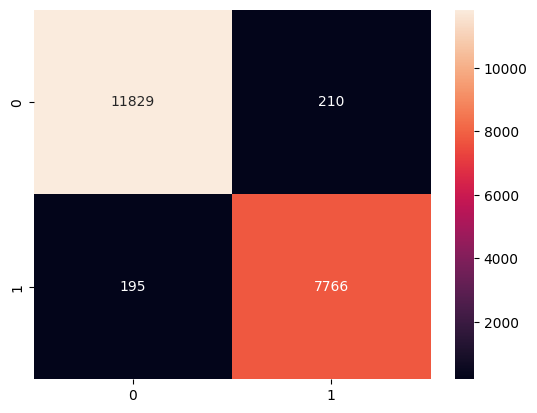

3. Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     12039
           1       0.97      0.98      0.97      7961

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000
 

4. ROC Curve & AUC Scores:



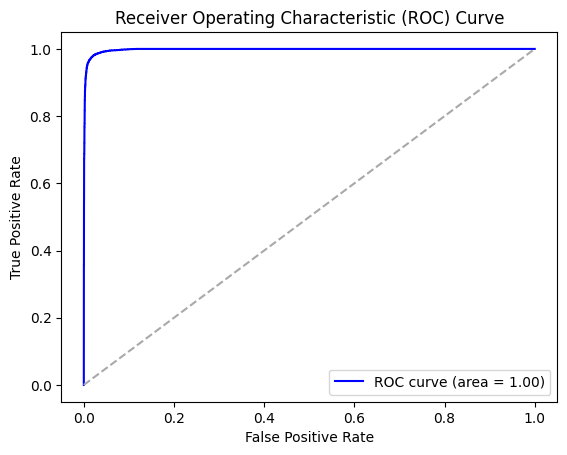

AUC Score: 0.9978820821193491



In [15]:
classifier = xgb_model(X_train, X_test, y_train, y_test)

In [16]:
dump(classifier, 'xgb_model_base.joblib')

['xgb_model_base.joblib']